
# Analysis of the prediction results

The aim of this notebook is to retrieve which samples in the training data were wrongly classified.
For a subset of the mis-classfied results, it shows the inputs fed into the model and the models' output certainty,
so as to allow visualisation of the process and potentially pinpoint what caused the issue.

## Retrieval of misclassified samples

In [6]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from src.data_processing.data_loader import transform_to_trio_MNIST, prepare_for_model_training
from src.data_processing.number_extraction import extract_3_and_paste, extract_k_numbers
from src.models.max_mnist_predictor import MaxMNISTPredictor
from src.models.models import get_model
from src.triplet_predictions import train as train_triplet
from src.isolated_prediction import train as train_isolated
from src.util.fileio import load_pkl_file, load_training_labels, show_image, load_model, load_modified_MNIST_training
from src.config import data_path, training_images_file, training_labels_file_name, retrain_models, models_path, \
    MNIST_PIXEL, NUM_CATEGORIES, transfer_learning, ISOLATED_PRED_DATASET, MODEL, NUMBERS_PER_PICTURE, \
    REMOVE_BACKGROUND_TRIO

# can be TRIPLET or ISOLATED
PREDICTOR = "ISOLATED"

# here, train the model if not already trained
# Instantiate the appropriate model from config.py
if PREDICTOR == "TRIPLET":
    print("Evaluating Triplet predictions with model " + MODEL + " and with background removal", REMOVE_BACKGROUND_TRIO)

    print("Loading modified MNIST train dataset")
    x_train, y_train = load_modified_MNIST_training()

    print("Transforming training set to Triplet set")
    x_triplet, y_triplet = transform_to_trio_MNIST(x_train, y_train)
    x_triplet = prepare_for_model_training(x_triplet)
    del x_train
    del y_train

    # Instantiate the appropriate model
    model = get_model(MODEL, input_shape=(MNIST_PIXEL, NUMBERS_PER_PICTURE * MNIST_PIXEL, 1),
                      num_categories=NUM_CATEGORIES)
    model_path = os.path.join(models_path, "TRIPLET_" + MODEL + "_removeback" + str(REMOVE_BACKGROUND_TRIO) + ".h5")

    split = 0.8

    if not retrain_models:
        try:
            # Try to load the weights if we do not want to retrain
            load_model(model_path, model)
            model.summary()
        except:
            print("\tThe model file cannot be found at " + model_path + " so it will be retrained.")
            train_triplet(model, x_triplet, y_triplet, split)
    else:
        if transfer_learning:
            try:
                load_model(model_path, model)
                print("Transfer learning enabled, loaded old weights")
            except:
                print("Transfer learning enabled but no old weights exist")
        train_triplet(model, x_triplet, y_triplet, split)
        
elif PREDICTOR == "ISOLATED":
    model = get_model(MODEL, input_shape=(MNIST_PIXEL, MNIST_PIXEL, 1), num_categories=NUM_CATEGORIES)
    model_path = os.path.join(models_path, "ISOLATED_" + MODEL + "_" + ISOLATED_PRED_DATASET + ".h5")
    if not retrain_models:
        try:
            # Try to load the weights if we do not want to retrain
            load_model(model_path, model)
            model.summary()
        except:
            print("\tThe model file cannot be found at " + model_path + " so it will be retrained.")
            train_isolated(model)
    else:
        if transfer_learning:
            try:
                load_model(model_path, model)
                print("Transfer learning enabled, loaded old weights")
            except:
                print("Transfer learning enabled but no old weights exist")
        train_isolated(model)

# Once model is found, predict on train data
training_images_file_path = os.path.join(data_path, training_images_file)
training_labels_file_path = os.path.join(data_path, training_labels_file_name)
x_train = load_pkl_file(training_images_file_path)
y_train = load_training_labels(training_labels_file_path)

# Predict output
print("\tPredicting data to model: " + MODEL)
if PREDICTOR == "TRIPLET":
    x_train_trio = transform_to_trio_MNIST(x_train)
    x_train_trio = prepare_for_model_training(x_train_trio)
    y_predicted = model.predict(x_train_trio).argmax(axis=1)
else:
    y_predicted = MaxMNISTPredictor(model).predict_max_num(x_train)

# print the wrongly classified samples
df = pd.DataFrame()
df["actual"] = y_train
df["predicted"] = y_predicted
incorrect = df[df["actual"] != df["predicted"]]
print("There is a total of " + str(incorrect.shape[0]) + " incorrect predictions")
print(incorrect)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
batch_normalization_8 (Batch (None, 26, 26, 32)        128       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
batch_normalization_9 (Batch (None, 24, 24, 32)        128       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 12, 12, 32)        25632     
_________________________________________________________________
batch_normalization_10 (Batc (None, 12, 12, 32)        128       
_________________________________________________________________
dropout_4 (Dropout)          (None, 12, 12, 32)        0         
__________

In [7]:
def plot_bar_pred_score(values):
    # this is for plotting purpose
    index = np.arange(10)
    plt.bar(index, values)
    plt.xlabel('Classification', fontsize=5)
    plt.ylabel('Percentage score', fontsize=5)
    plt.xticks(index, range(10), fontsize=5, rotation=30)
    plt.title('Classification score')
    plt.show()

## Subset analysis

Now, from the gathered predictions, print the original images of the first N wrongly classified samples.
Also, depending on which model was chosen, print the processed image that was fed to the model.

From the gathered predictions, show the model's evaluation on all classifications of of the first N wrongly classified samples.

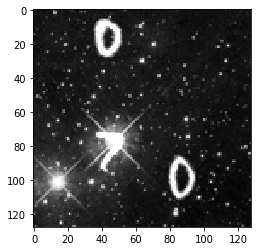

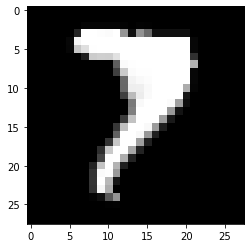

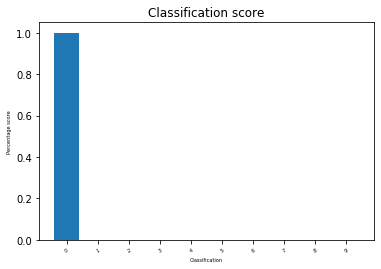

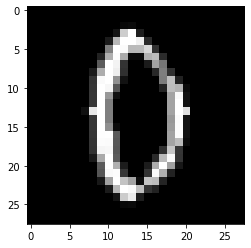

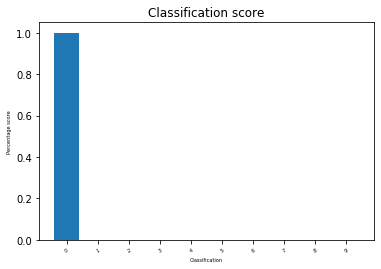

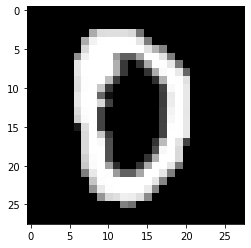

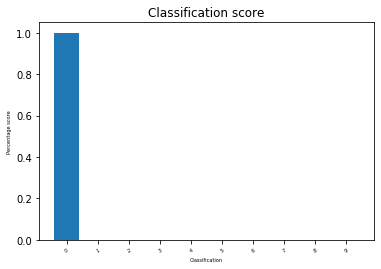

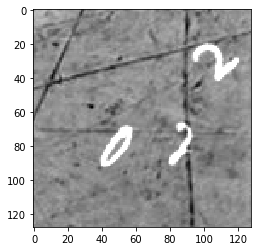

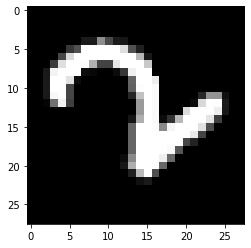

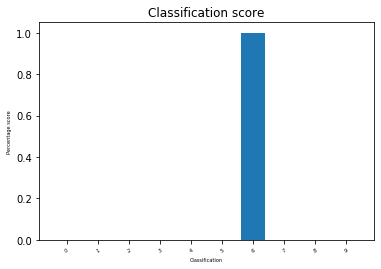

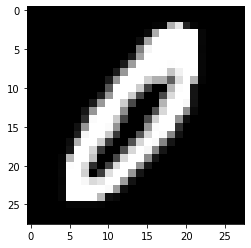

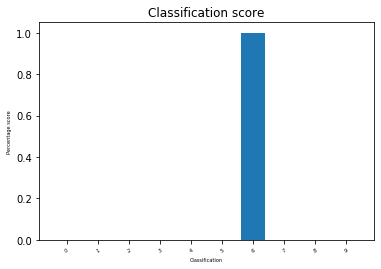

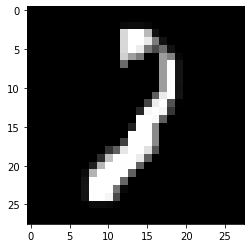

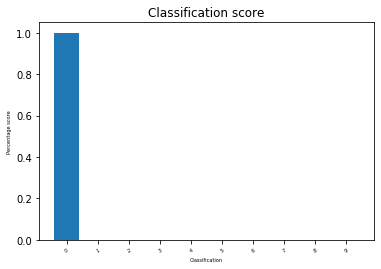

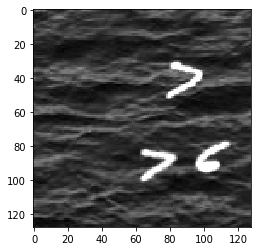

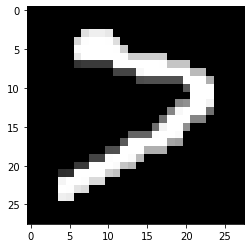

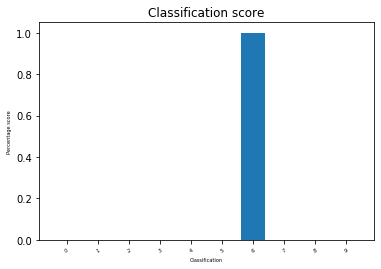

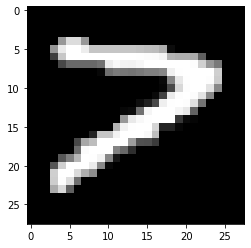

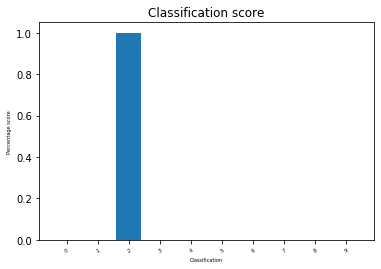

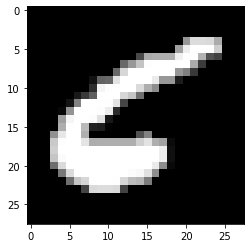

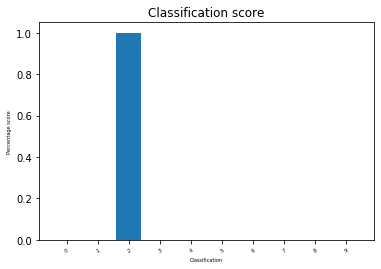

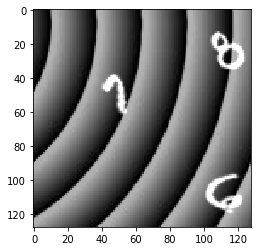

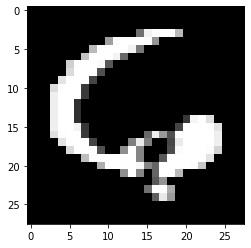

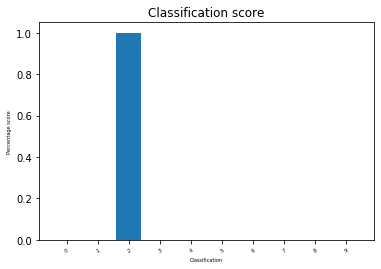

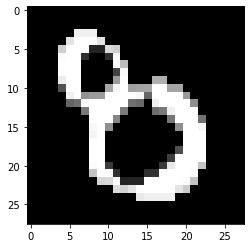

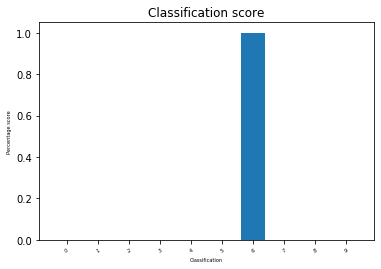

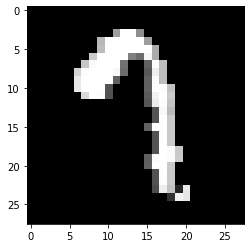

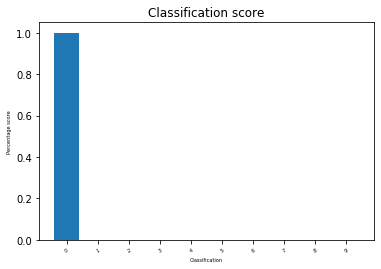

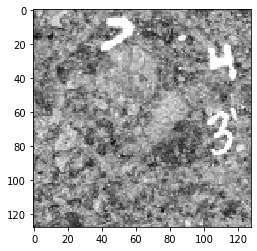

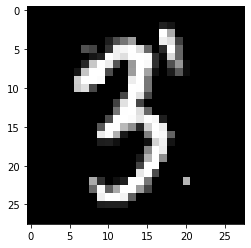

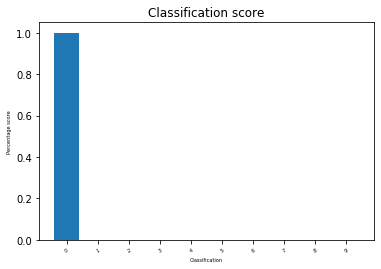

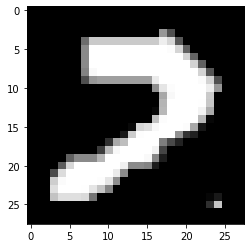

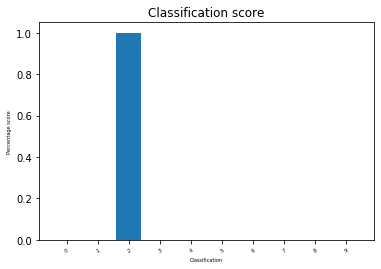

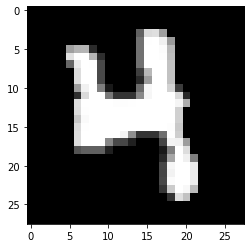

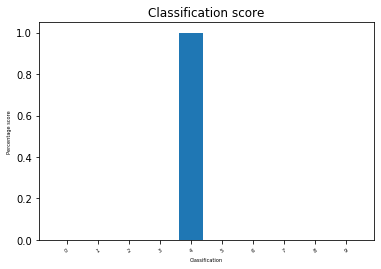

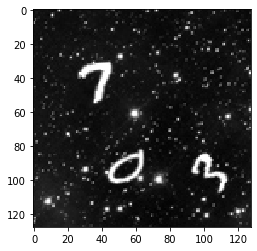

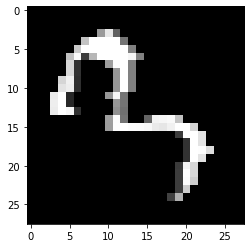

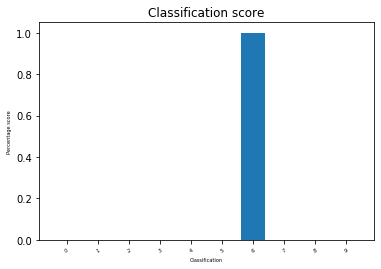

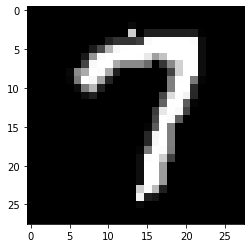

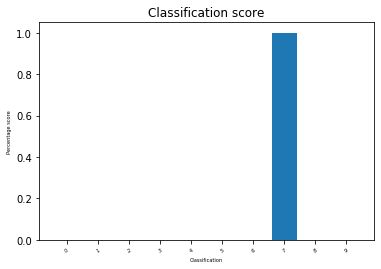

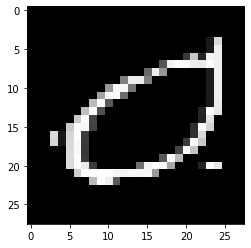

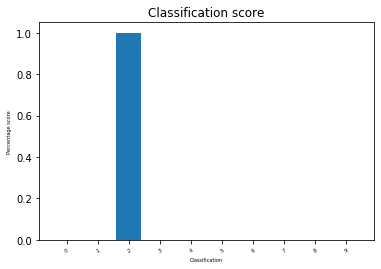

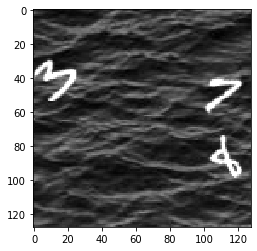

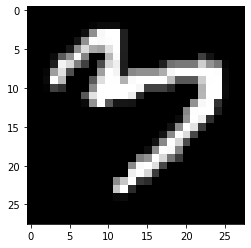

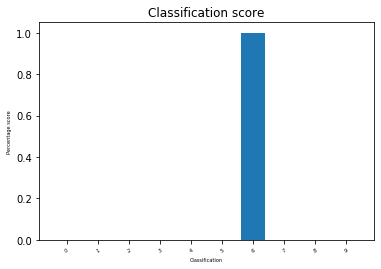

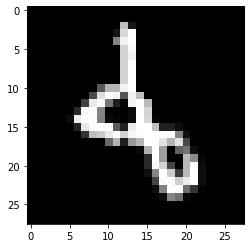

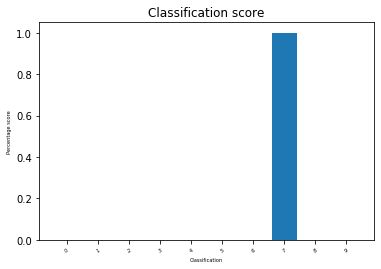

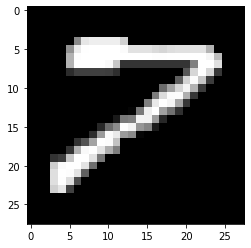

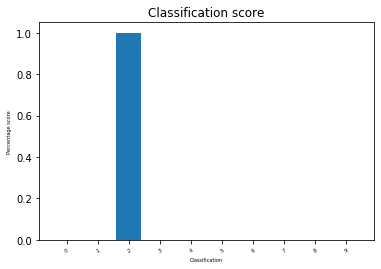

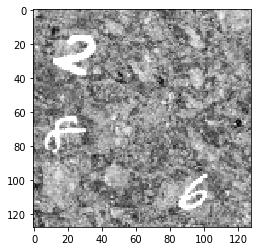

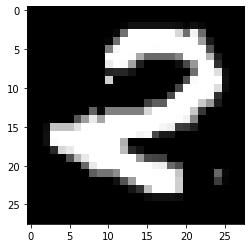

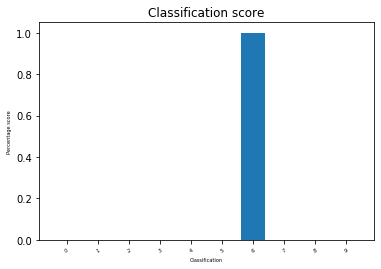

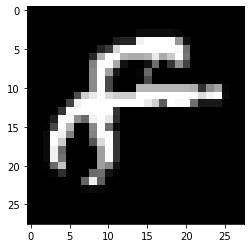

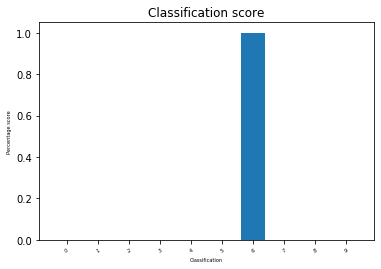

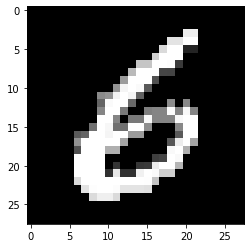

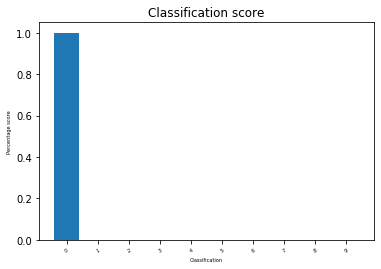

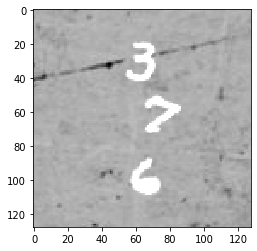

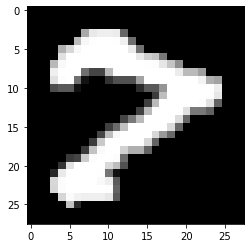

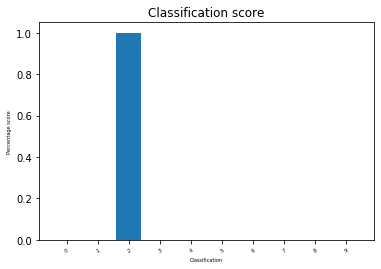

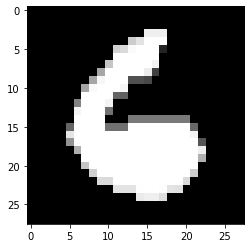

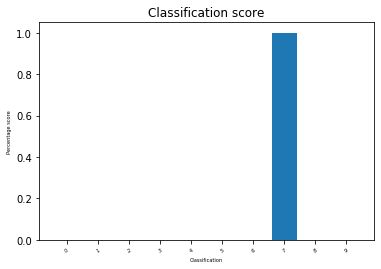

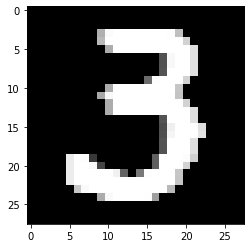

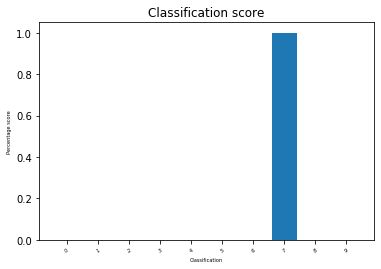

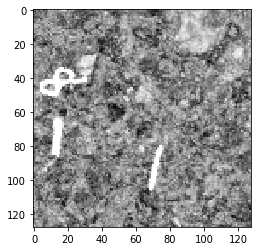

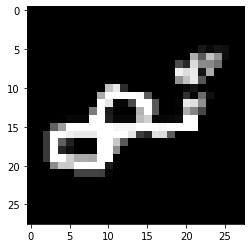

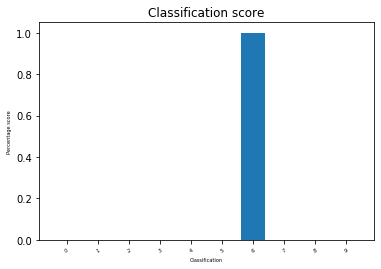

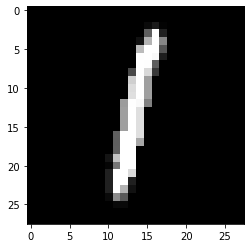

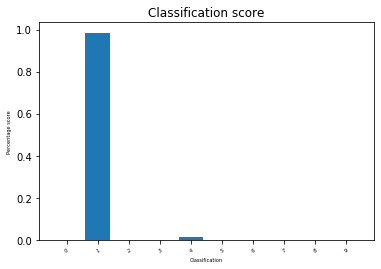

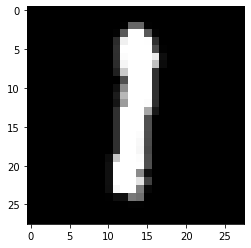

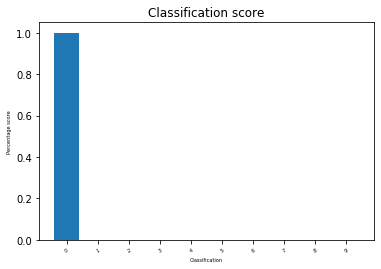

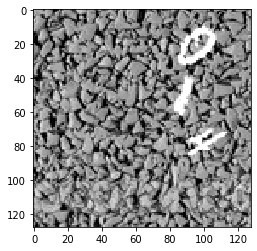

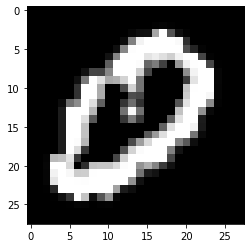

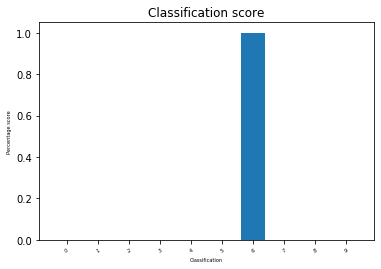

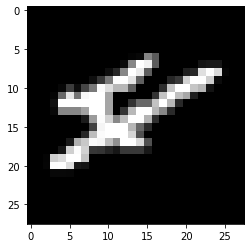

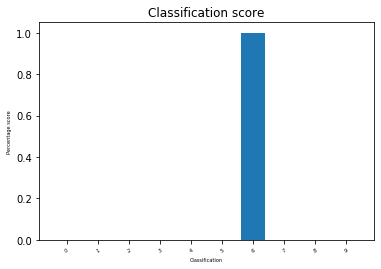

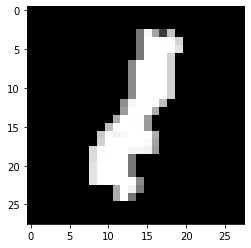

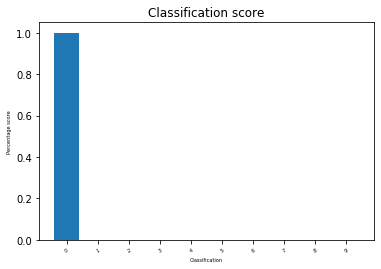

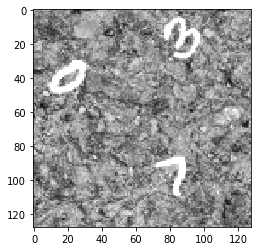

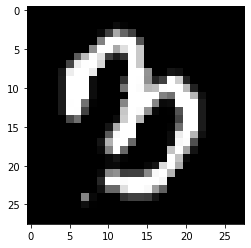

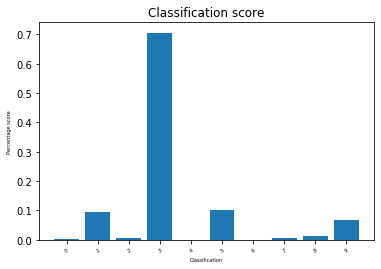

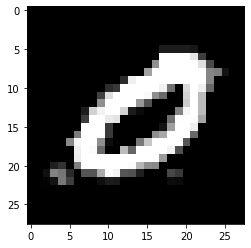

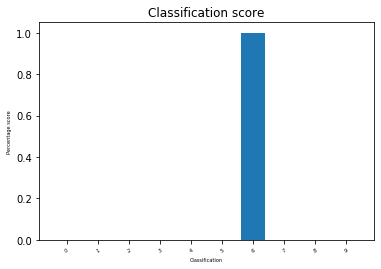

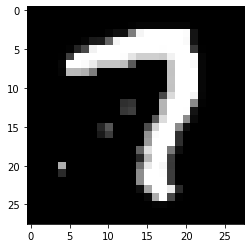

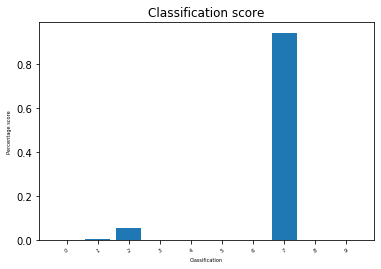

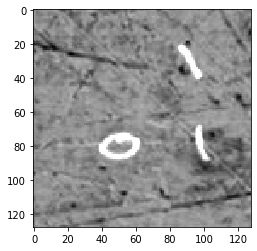

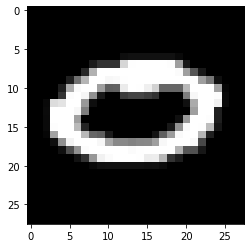

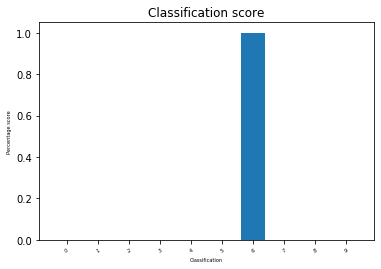

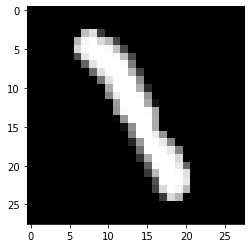

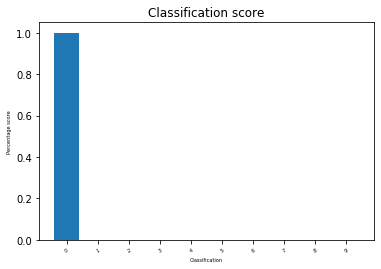

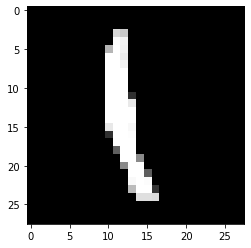

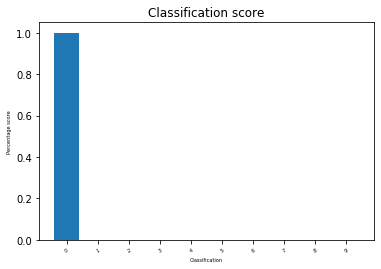

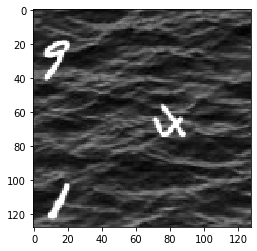

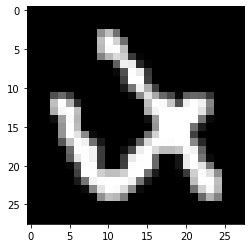

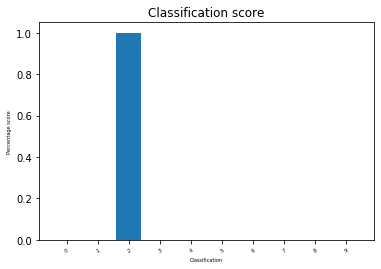

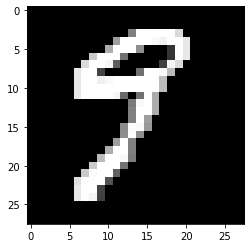

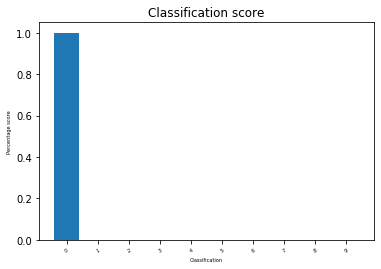

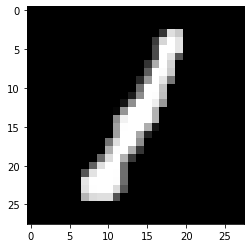

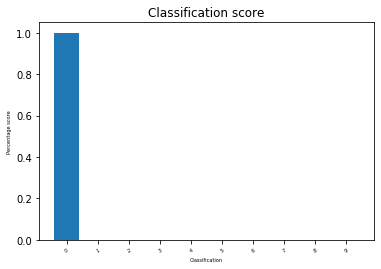

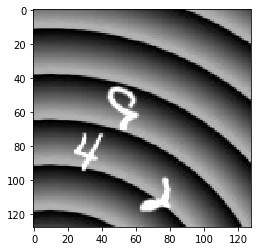

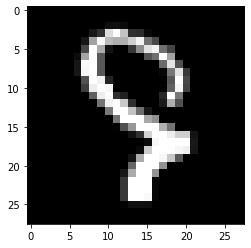

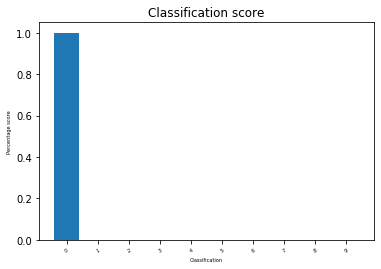

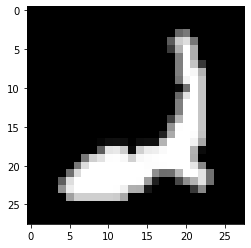

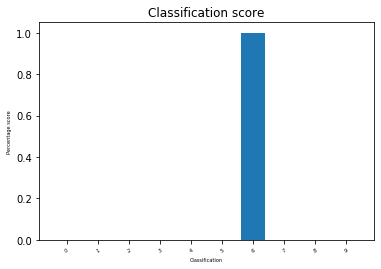

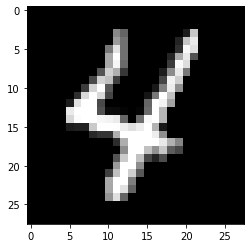

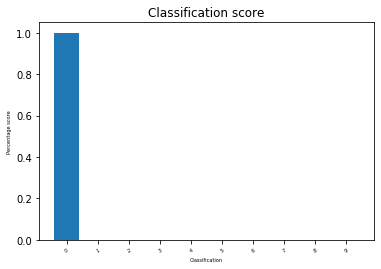

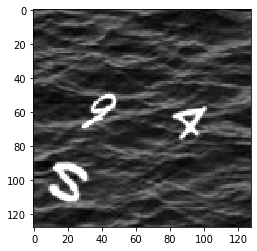

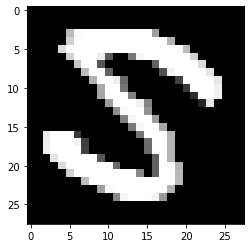

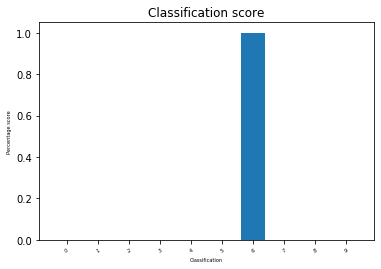

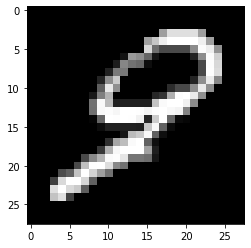

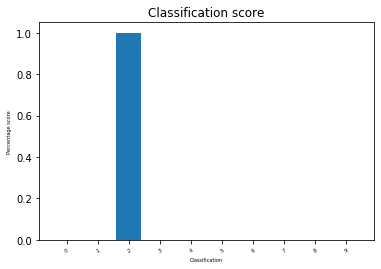

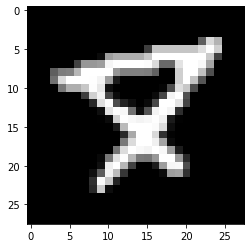

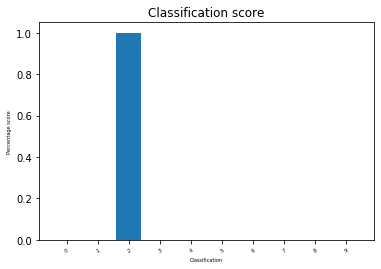

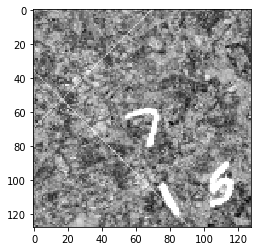

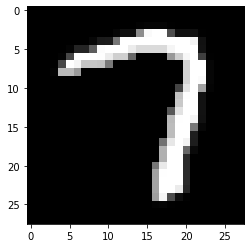

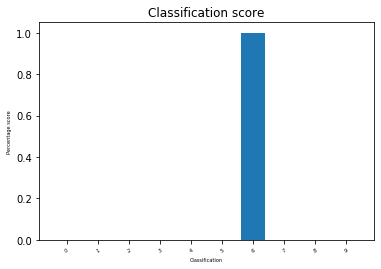

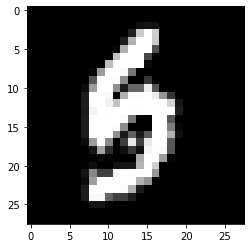

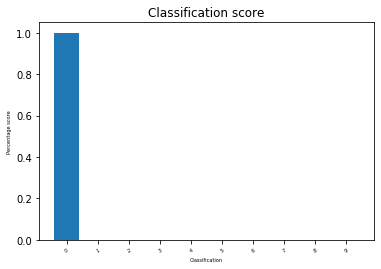

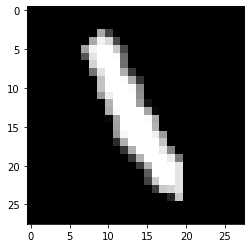

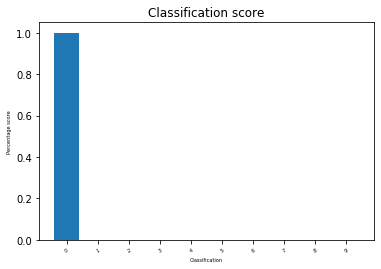

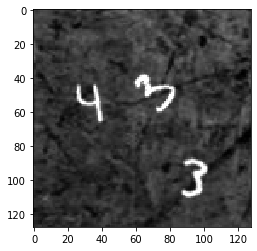

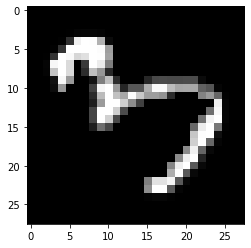

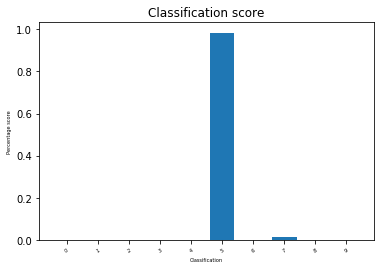

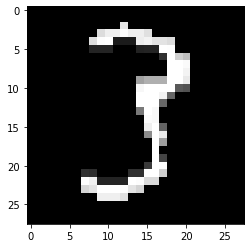

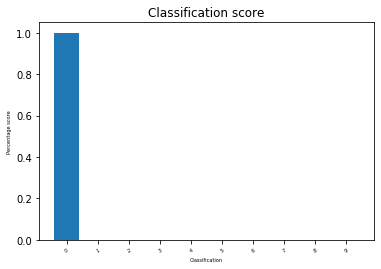

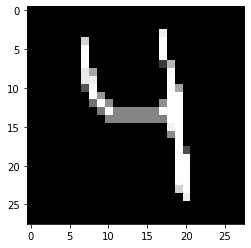

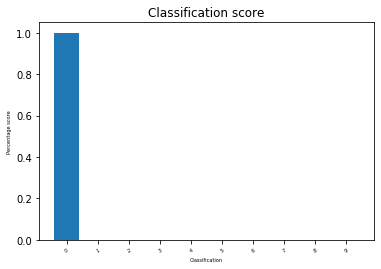

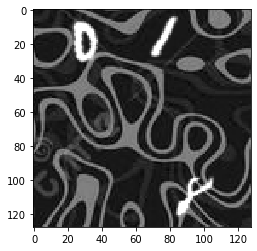

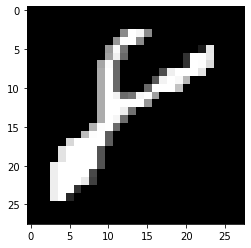

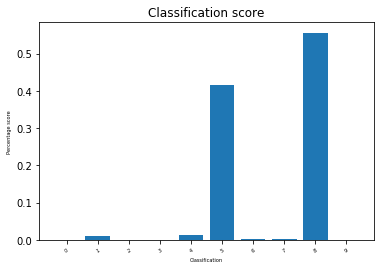

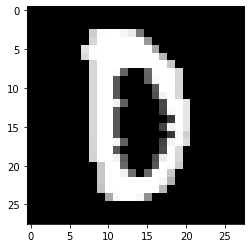

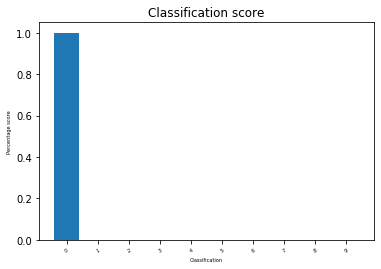

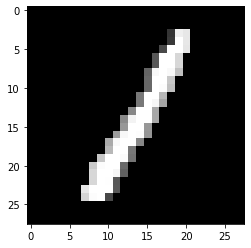

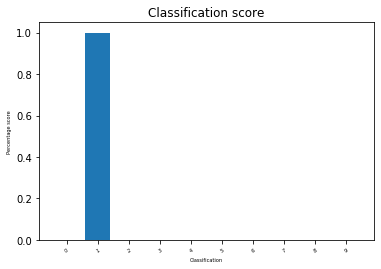

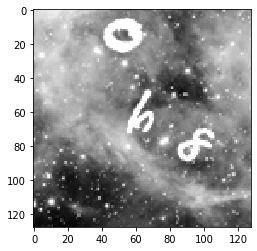

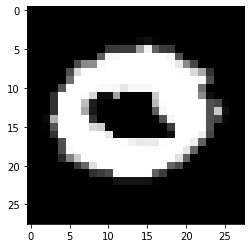

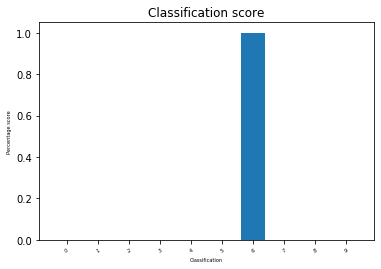

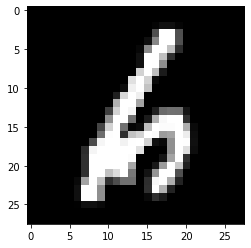

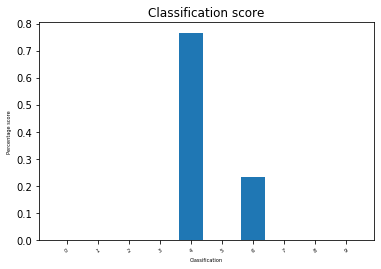

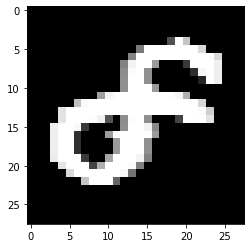

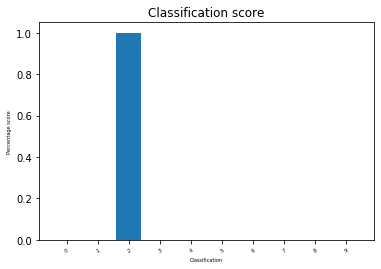

In [13]:
NB_ERRORS =20
subset_incorrect = incorrect.head(NB_ERRORS)

if PREDICTOR == "ISOLATED":
    # print the 3 unique images
    for sample_id in subset_incorrect.index:
        # print the original image
        image = x_train[sample_id]
        show_image(image)
        
        # print the extracted numbers image and their pred score
        extracted_numbers = extract_k_numbers(image)
        for extracted_nb in extracted_numbers:
            show_image(extracted_nb)
            extracted_nb = prepare_for_model_training(extracted_nb)
            extracted_prediction_score = model.predict_proba(extracted_nb[np.newaxis, ...])[0]
            plot_bar_pred_score(extracted_prediction_score)
            
elif PREDICTOR == "TRIPLET":
    for sample_id in subset_incorrect.index:
        # print the original image
        image = x_train[sample_id]
        show_image(image)
        
        # print the combined images
        trio = extract_3_and_paste(image, get_permutations = False)
        show_image(trio)
        
        # get the prediction score for the given sample
        trio = prepare_for_model_training(trio)
        prediction_score = model.predict_proba(trio[np.newaxis, ...])[0]
        plot_bar_pred_score(prediction_score)
        

In [12]:
nb_poss_vals = []

if PREDICTOR == "ISOLATED":
    # print the 3 unique images
    for image in x_train:
        extracted_numbers = extract_k_numbers(image)
        for extracted_nb in extracted_numbers:
            extracted_nb = prepare_for_model_training(extracted_nb)
            extracted_prediction_score = model.predict_proba(extracted_nb[np.newaxis, ...])[0]
            
            # try to find how many possible values the model is hesitating around
            mask = np.where(extracted_prediction_score > 0.2)
            possible_values_percentage = extracted_prediction_score[mask]
            if possible_values_percentage.shape[0] != 0:
                nb_poss_vals.append(possible_values_percentage.shape[0])

elif PREDICTOR == "TRIPLET":
    for image in x_train:
        trio = extract_3_and_paste(image, get_permutations = False)
        trio = prepare_for_model_training(trio)
        prediction_score = model.predict_proba(trio[np.newaxis, ...])[0]
        
        # try to find how many possible values the model is hesitating around
        mask = np.where(prediction_score > 0.2)
        possible_values_percentage = prediction_score[mask]
        if possible_values_percentage.shape[0] != 0:
            nb_poss_vals.append(possible_values_percentage.shape[0])
    
print("Average number of possible classes for a digit: " + str(np.asarray(nb_poss_vals).mean()))



Average number of possible classes for a digit:1.0346066666666667
